In [1]:
from plotter_utils import *

# globals
model_name = 'gpt-3.5-turbo-0613'
cpd_dataset_folder = 'datasets/cpd_debates'
cpd_raw_debates_folder = f'{cpd_dataset_folder}/cpd_debates_raw'
cpd_slices_folder = f'{cpd_dataset_folder}/cpd_debates_slices'
cpd_slices_texts_folder = f'{cpd_dataset_folder}/cpd_debates_slices_text'
cpd_measurements_folder = f'{cpd_dataset_folder}/cpd_debates_measurements'
plots_folder = 'plots'
observable_ensemble_plots_folder = f'{plots_folder}/observable_ensemble_plots'
observable_single_vs_multi_speaker_pairplots_folder = f'{plots_folder}/single_vs_multi_speaker_pairplots'
observable_single_vs_multi_speaker_overview_folder = f'{plots_folder}/single_vs_multi_speaker_overview'

report_latex_folder = 'report/sec/code_info/'

debates_d, slices_d, paragraphs_d = load_dataset()
speaker_measurements = load_speaker_measurements()
slice_speaker_base_observables = load_slice_and_measured_observables(slices_d)

In [2]:
SS_SSO = speaker_measurements['WS_SS_SSO_measurements']

SS_SSO_grouped_df, n_raw_observables, n_grouped_observables = prepare_speaker_observables(slice_speaker_base_observables, SS_SSO)

SS_SSO_grouped_candidates_only_df = SS_SSO_grouped_df[SS_SSO_grouped_df['speaker_party_is_UNKNOWN'] == 0]
SS_SSO_grouped_candidates_only_df = SS_SSO_grouped_candidates_only_df.drop(columns=['speaker_party_is_UNKNOWN'])

# heatmap of correlations
SS_SSO_corr = SS_SSO_grouped_candidates_only_df.corr()
SS_SSO_corr = SS_SSO_corr.sort_values(by=['score'], ascending=False)
SS_SSO_corr = SS_SSO_corr.sort_values(by=['score'], axis=1, ascending=False)

In [3]:
MS_SSO = speaker_measurements['WS_MS_SSO_measurements']

MS_SSO_grouped_df, n_raw_observables, n_grouped_observables = prepare_speaker_observables(slice_speaker_base_observables, MS_SSO)

MS_SSO_grouped_candidates_only_df = MS_SSO_grouped_df[MS_SSO_grouped_df['speaker_party_is_UNKNOWN'] == 0]
MS_SSO_grouped_candidates_only_df = MS_SSO_grouped_candidates_only_df.drop(columns=['speaker_party_is_UNKNOWN'])

# heatmap of correlations
MS_SSO_corr = MS_SSO_grouped_candidates_only_df.corr()
MS_SSO_corr = MS_SSO_corr.sort_values(by=['score'], ascending=False)
MS_SSO_corr = MS_SSO_corr.sort_values(by=['score'], axis=1, ascending=False)

In [4]:
# compbine dfs
df_ss = SS_SSO_grouped_candidates_only_df.copy()
df_ms = MS_SSO_grouped_candidates_only_df.copy()

measured_observables = list(speaker_predictor_observables_groups.keys()) + list(speaker_result_observables_groups.keys())

observables_ms_vs_ss = {}
dfs_ms_vs_ss = {}
dfs_slice_internal_ms_vs_ss = {}
for observable in measured_observables:
    std_entries = {}
    slice_internal_entries = {}
    for i, row in df_ms.iterrows():
        key = f'{row["slice_id"]}_{row["speaker"]}'
        std_entries[key] = std_entries.get(key, {})
        std_entries[key]['Multiple Speakers'] = row[observable]
        
        key = row['slice_id']
        slice_internal_entries[key] = slice_internal_entries.get(key, {})
        slice_internal_entries[key]['Multiple Speakers'] = slice_internal_entries[key].get('Multiple Speakers', [])
        slice_internal_entries[key]['Multiple Speakers'].append(row[observable])
    for i, row in df_ss.iterrows():
        key = f'{row["slice_id"]}_{row["speaker"]}'
        std_entries[key] = std_entries.get(key, {})
        std_entries[key]['Single Speaker'] = row[observable]

        key = row['slice_id']
        slice_internal_entries[key] = slice_internal_entries.get(key, {})
        slice_internal_entries[key]['Single Speaker'] = slice_internal_entries[key].get('Single Speaker', [])
        slice_internal_entries[key]['Single Speaker'].append(row[observable])
    # remove all that don't have both
    std_entries = {k:v for k,v in std_entries.items() if len(v)==2}
    slice_internal_entries = {k:v for k,v in slice_internal_entries.items() if len(v)==2}

    std_entries = [{'index': k, **v} for k,v in std_entries.items()]
    df = pd.DataFrame(std_entries)
    df = df.dropna()
    dfs_ms_vs_ss[observable] = df

    e = []
    for key, val in slice_internal_entries.items():
        ssv = val['Single Speaker']
        msv = val['Multiple Speakers']

        e.append({
            'index': key,
            'ss_mean': np.mean(ssv),
            'ss_std': np.std(ssv),
            'ms_mean': np.mean(msv),
            'ms_std': np.std(msv),
            'mean_diff': np.mean(msv)-np.mean(ssv),
            'std_diff': np.std(msv)-np.std(ssv),
        })
    df = pd.DataFrame(e)
    df.dropna(inplace=True)
    dfs_slice_internal_ms_vs_ss[observable] = df

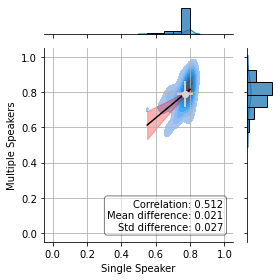

In [5]:
# create pairplot for each ensemble
if not os.path.exists(observable_single_vs_multi_speaker_pairplots_folder):
    os.makedirs(observable_single_vs_multi_speaker_pairplots_folder)

correlations = {}
mean_differences = {}
std_differences = {}

# move score to front
measured_observables.remove('score')
measured_observables.insert(0, 'score')
for observable in measured_observables:
    df = dfs_ms_vs_ss[observable]
    # df = pd.DataFrame()
    # df['Single Speaker'] = SS_SSO_grouped_candidates_only_df[observable]
    # df['Multiple Speakers'] = MS_SSO_grouped_candidates_only_df[observable]

    correlations[observable] = df['Multiple Speakers'].corr(df['Single Speaker'])
    mean_differences[observable] = (df['Multiple Speakers'].mean()-df['Single Speaker'].mean())
    std_differences[observable] = (df['Multiple Speakers'].std()-df['Single Speaker'].std())
    # correlations[observable] = df_ss[observable].corr(df_ms[observable])
    # mean_differences[observable] = df_ss[observable].mean()-df_ms[observable].mean()
    # std_differences[observable] = df_ss[observable].std()-df_ms[observable].std()

    # print(f'{observable:<30}\t{correlations[observable]:.3f}')

    # plt.figure(figsize=(5,5))
    # g = sns.kdeplot(x=df['Single Speaker'], y=df['Multiple Speakers']) # TODO: add plots on side
    g = sns.jointplot(x=df['Single Speaker'], y=df['Multiple Speakers'], kind='kde', fill=True, space=1.0)
    # add grid
    g.fig.axes[0].grid()
    # add xlim and ylim
    g.fig.axes[0].set_xlim(-0.05, 1.05)
    g.fig.axes[0].set_ylim(-0.05, 1.05)
    # set better size for so that text readable
    g.fig.set_size_inches(4, 4)
    # add marginals
    g.plot_marginals(sns.histplot, bins=5) #, kde=True)
    # # Add histogram marginals
    # g.plot_marginals(sns.histplot, color='skyblue')
    # # Add kde marginals
    # g.plot_marginals(sns.kdeplot, color='black', fill=True)

    # add linear regression in black and error band lines in gray
    # ci = 99
    z_score_for_ci_99 = 2.576
    # sns.regplot(x=df['Single Speaker'], y=df['Multiple Speakers'], scatter=False, ax=g.ax_joint, color='black', line_kws={'linewidth': 1}, ci=ci)

    # Perform a linear regression
    x = df['Single Speaker']
    y = df['Multiple Speakers']

    # Fit the model
    X = sm.add_constant(x)
    model = sm.OLS(y, X)
    results = model.fit()

    # Predict values
    xp = np.linspace(x.min(), x.max(), 100)
    Xp = sm.add_constant(xp)
    ypred = results.predict(Xp)

    # Get standard deviation of predicted values
    pred_std = results.get_prediction(Xp).se_mean

    # Calculate confidence intervals
    ci_low = ypred - z_score_for_ci_99 * pred_std
    ci_upp = ypred + z_score_for_ci_99 * pred_std

    # Add the regression line and confidence intervals
    g.ax_joint.plot(xp, ypred, color='black')
    g.ax_joint.fill_between(xp, ci_low, ci_upp, color='red', alpha=0.3)

    # add the correlation and the resective means and stds, text in bottom right (not left!)
    text = f'Correlation: {correlations[observable]:.3f}\nMean difference: {mean_differences[observable]:.3f}\nStd difference: {std_differences[observable]:.3f}'
    g.fig.axes[0].text(0.95, 0.05, text, transform=g.fig.axes[0].transAxes, verticalalignment='bottom', horizontalalignment='right', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    
    # add vertical and horizontal lines (lightgray) for the means of both with error bars (black)
    # g.ax_joint.axvline(x=df['Single Speaker'].mean(), color='lightgray', linestyle='--')
    # g.ax_joint.axhline(y=df['Multiple Speakers'].mean(), color='lightgray', linestyle='--')
    g.ax_joint.errorbar(x=df['Single Speaker'].mean(), y=df['Multiple Speakers'].mean(), xerr=df['Single Speaker'].std(), yerr=df['Multiple Speakers'].std(), fmt='o', color='lightgray')
    g.ax_joint.errorbar(x=df['Single Speaker'].mean(), y=df['Multiple Speakers'].mean(), xerr=df['Single Speaker'].std(), yerr=df['Multiple Speakers'].std(), fmt='o', color='lightgray')



    # g.ax_joint.axvline(x=df['Single Speaker'].mean(), color='black', linestyle='--')
    # g.ax_joint.axhline(y=df['Multiple Speakers'].mean(), color='black', linestyle='--')
    # g.ax_joint.errorbar(x=df['Single Speaker'].mean(), y=df['Multiple Speakers'].mean(), xerr=df['Single Speaker'].std(), yerr=df['Multiple Speakers'].std(), fmt='o', color='black')
    # g.ax_joint.errorbar(x=df['Single Speaker'].mean(), y=df['Multiple Speakers'].mean(), xerr=df['Single Speaker'].std(), yerr=df['Multiple Speakers'].std(), fmt='o', color='black')

    # plt.grid()
    # plt.xlim(-0.05, 1.05)
    # plt.ylim(-0.05, 1.05)
    # g = sns.pairplot(df, diag_kind='kde')
    # g.map_upper(sns.regplot)
    # g.map_lower(sns.kdeplot)
    # g.fig.set_size_inches(4, 4)
    # change names of columns
    # for ax in g.axes.flatten():
    #     if ax:
    #         ax.set_xlabel(ax.get_xlabel().split('(')[-1].split(')')[0])
    #         ax.set_ylabel(ax.get_ylabel().split('(')[-1].split(')')[0])

    # make tight layout so that axis is not cut
    plt.tight_layout()
    plt.savefig(f'{observable_single_vs_multi_speaker_pairplots_folder}/{observable}_pairplot.png', dpi=300)
    if observable=='score':
        plt.show()
    plt.close()

0.0013 32.91% 0.1078


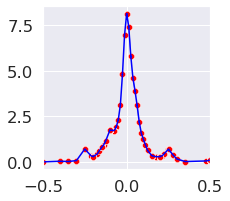

0.0740 54.11% 0.1709


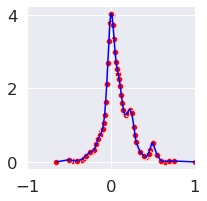

In [6]:
collected_diffs_mean = []
collected_diffs_std = []

for observable in measured_observables:
    df = dfs_slice_internal_ms_vs_ss[observable]

    # collected_diffs_mean.append(df['mean_diff'].mean())
    # collected_diffs_std.append(df['std_diff'].mean())

    # normalize std diffs
    std_diffs = df['std_diff'].to_numpy()
    # std_diffs = std_diffs - std_diffs.mean()
    for std_diff in std_diffs:
        collected_diffs_std.append(std_diff)

    # normalize mean diffs
    mean_diffs = df['mean_diff'].to_numpy()
    # mean_diffs = mean_diffs - mean_diffs.mean()
    for mean_diff in mean_diffs:
        collected_diffs_mean.append(mean_diff)

# sns.histplot(collected_diffs_std, bins=10, legend=False) #, kde=True)
# plt.show()

def plot_kde_with_points(x):
    from scipy.stats import gaussian_kde

    # Compute KDE
    kde = gaussian_kde(x)

    # Evaluate the KDE on the grid
    y = kde.evaluate(x)

    # increase the font size
    sns.set(font_scale=1.5)
    # Plot KDE curve
    plt.figure(figsize=(3,3))
    # get max of abs of x
    max_x = max(abs(min(x)), abs(max(x)))
    plt.xlim(-max_x, max_x)
    sns.lineplot(x=x, y=y, color='blue')

    # Plot the actual data points on the KDE curve
    sns.scatterplot(x=x, y=y, color='red')

    # sns grid
    sns.set_style("whitegrid")
    # plt.grid()

if not os.path.exists(observable_single_vs_multi_speaker_overview_folder):
    os.makedirs(observable_single_vs_multi_speaker_overview_folder)

percentage_bigger = np.sum(np.array(collected_diffs_std) > 0) / len(collected_diffs_std) * 100
print(f'{np.mean(collected_diffs_std):.4f} {percentage_bigger:.2f}% {np.std(collected_diffs_std):.4f}')
plot_kde_with_points(collected_diffs_std)
plt.savefig(f'{observable_single_vs_multi_speaker_overview_folder}/internal_ms_minus_ss_std_kde.png', dpi=300)
plt.show()
percentage_bigger = np.sum(np.array(collected_diffs_mean) > 0) / len(collected_diffs_mean) * 100
print(f'{np.mean(collected_diffs_mean):.4f} {percentage_bigger:.2f}% {np.std(collected_diffs_mean):.4f}')
plot_kde_with_points(collected_diffs_mean)
plt.savefig(f'{observable_single_vs_multi_speaker_overview_folder}/internal_ms_minus_ss_mean_kde.png', dpi=300)
plt.show()

In [7]:
# # visualize slice internal differences
# for observable in measured_observables:
#     print(observable)
#     df = dfs_slice_internal_ms_vs_ss[observable]

#     sns.pairplot(df, vars=['ss_mean', 'ms_mean'])
#     plt.show()
#     sns.pairplot(df, vars=['ss_std', 'ms_std'])
#     plt.show()
#     # sns.catplot(df, x=['ss_mean', 'ms_mean', 'ss_std', 'ms_std'])
#     sns.histplot(df['mean_diff'])
#     plt.show()
#     sns.histplot(df['std_diff'])
#     plt.show()
#     sns.histplot(df[['ss_mean', 'ms_mean']])
#     plt.show()
#     sns.histplot(df[['ss_std', 'ms_std']])
#     plt.show()

#     break

std
0.0152 69.70% 0.0456


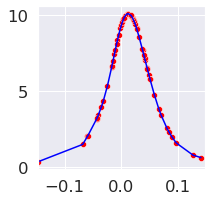

mean
0.0740 83.33% 0.0852


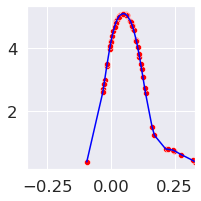

In [8]:
# histogram of variance and mean for multi and single

ms_stds = []
ss_stds = []
ms_means = []
ss_means = []

std_entries = []
mean_entries = []
for observable in measured_observables:
    df = dfs_ms_vs_ss[observable]
    ms_stds.append(df['Multiple Speakers'].std())
    ss_stds.append(df['Single Speaker'].std())
    ms_means.append(df['Multiple Speakers'].mean())
    ss_means.append(df['Single Speaker'].mean())

    std_entries.append({
        'Multiple Speakers': df['Multiple Speakers'].std(),
        'Single Speaker': df['Single Speaker'].std(),
    })

    mean_entries.append({
        'Multiple Speakers': df['Multiple Speakers'].mean(),
        'Single Speaker': df['Single Speaker'].mean(),
    })

std_df = pd.DataFrame(std_entries)
mean_df = pd.DataFrame(mean_entries)
# print(std_df.mean())
# print(mean_df.mean())
# sns.histplot(std_df) #, multiple='dodge', bins=5)
# plt.show()
# sns.histplot(mean_df) #, multiple='dodge', bins=5)
# plt.show()

print('std')
std_diff = std_df['Multiple Speakers']-std_df['Single Speaker']
percentage_bigger = (std_diff > 0).sum() / len(std_diff) * 100
print(f'{std_diff.mean():.4f} {percentage_bigger:.2f}% {std_diff.std():.4f}')
plot_kde_with_points(std_df['Multiple Speakers']-std_df['Single Speaker'])
plt.savefig(f'{observable_single_vs_multi_speaker_overview_folder}/external_ms_minus_ss_std_kde.png', dpi=300)
plt.show()
print('mean')
mean_diff = mean_df['Multiple Speakers']-mean_df['Single Speaker']
percentage_bigger = (mean_diff > 0).sum() / len(mean_diff) * 100
print(f'{mean_diff.mean():.4f} {percentage_bigger:.2f}% {mean_diff.std():.4f}')
plot_kde_with_points(mean_df['Multiple Speakers']-mean_df['Single Speaker'])
plt.savefig(f'{observable_single_vs_multi_speaker_overview_folder}/external_ms_minus_ss_mean_kde.png', dpi=300)
plt.show()

In [26]:
df_ss = SS_SSO_grouped_candidates_only_df.copy()
df_ms = MS_SSO_grouped_candidates_only_df.copy()
print(len(df_ss), len(df_ms))

# only keep slices where f'{slice_id}_{speaker}' is in both dfs
df_ss['slice_speaker'] = df_ss.apply(lambda x: f'{x.slice_id}_{x.speaker}', axis=1)
df_ms['slice_speaker'] = df_ms.apply(lambda x: f'{x.slice_id}_{x.speaker}', axis=1)
df_ss = df_ss[df_ss.slice_speaker.isin(df_ms.slice_speaker)]
df_ms = df_ms[df_ms.slice_speaker.isin(df_ss.slice_speaker)]

print(len(df_ss), len(df_ms))

for i in range(2, 91):
    if (i>10 and i%10!=0) or i%2!=0:
        continue

    corr_ss = kfold_cross_validation(df_ss, lambda x: x.corr(), lambda x: x.var(), n_splits=i, iterations=2000//i)
    corr_ms = kfold_cross_validation(df_ms, lambda x: x.corr(), lambda x: x.var(), n_splits=i, iterations=2000//i)

    m_ss = corr_ss.mean().mean()
    m_ms = corr_ms.mean().mean()
    m_ss_square = (corr_ss**2).mean().mean()
    m_ms_square = (corr_ms**2).mean().mean()
    print(f'{i} folds: {m_ss:.5f} vs {m_ms:.5f} (ss to ms ratio {m_ss/m_ms:.5f}), {m_ss_square:.5f} vs {m_ms_square:.5f} (ss to ms ratio {m_ss_square/m_ms_square:.5f})')

156 97
97 97
2 folds: 0.00967 vs 0.01019 (ss to ms ratio 0.94832), 0.00011 vs 0.00012 (ss to ms ratio 0.95229)
4 folds: 0.00325 vs 0.00338 (ss to ms ratio 0.96053), 0.00001 vs 0.00001 (ss to ms ratio 0.96805)
6 folds: 0.00194 vs 0.00203 (ss to ms ratio 0.95596), 0.00000 vs 0.00000 (ss to ms ratio 0.95711)
8 folds: 0.00138 vs 0.00144 (ss to ms ratio 0.96314), 0.00000 vs 0.00000 (ss to ms ratio 0.97624)
10 folds: 0.00108 vs 0.00113 (ss to ms ratio 0.96019), 0.00000 vs 0.00000 (ss to ms ratio 0.96170)
20 folds: 0.00051 vs 0.00053 (ss to ms ratio 0.95681), 0.00000 vs 0.00000 (ss to ms ratio 0.97027)
30 folds: 0.00033 vs 0.00035 (ss to ms ratio 0.95786), 0.00000 vs 0.00000 (ss to ms ratio 0.97610)
40 folds: 0.00025 vs 0.00026 (ss to ms ratio 0.95614), 0.00000 vs 0.00000 (ss to ms ratio 0.96928)
50 folds: 0.00020 vs 0.00021 (ss to ms ratio 0.95630), 0.00000 vs 0.00000 (ss to ms ratio 0.96967)
60 folds: 0.00017 vs 0.00017 (ss to ms ratio 0.97378), 0.00000 vs 0.00000 (ss to ms ratio 1.14180)
7

In [10]:
# correlations_s = dict(sorted(correlations.items(), key=lambda x: x[1], reverse=True))
# for key in correlations_s:
#     print(f'{key:<35}:\tCor={correlations_s[key]:.3f}\tMean Diff={mean_differences[key]:.3f}   \tMean Std={std_differences[key]:.3f}')

In [11]:
# mean_differences_s = dict(sorted(mean_differences.items(), key=lambda x: x[1], reverse=True))
# for key in mean_differences_s:
#     print(f'{key:<35}:\tCor={correlations[key]:.3f}\tMean Diff={mean_differences[key]:.3f}   \tMean Std={std_differences[key]:.3f}')

In [12]:
# print differences of std within single query


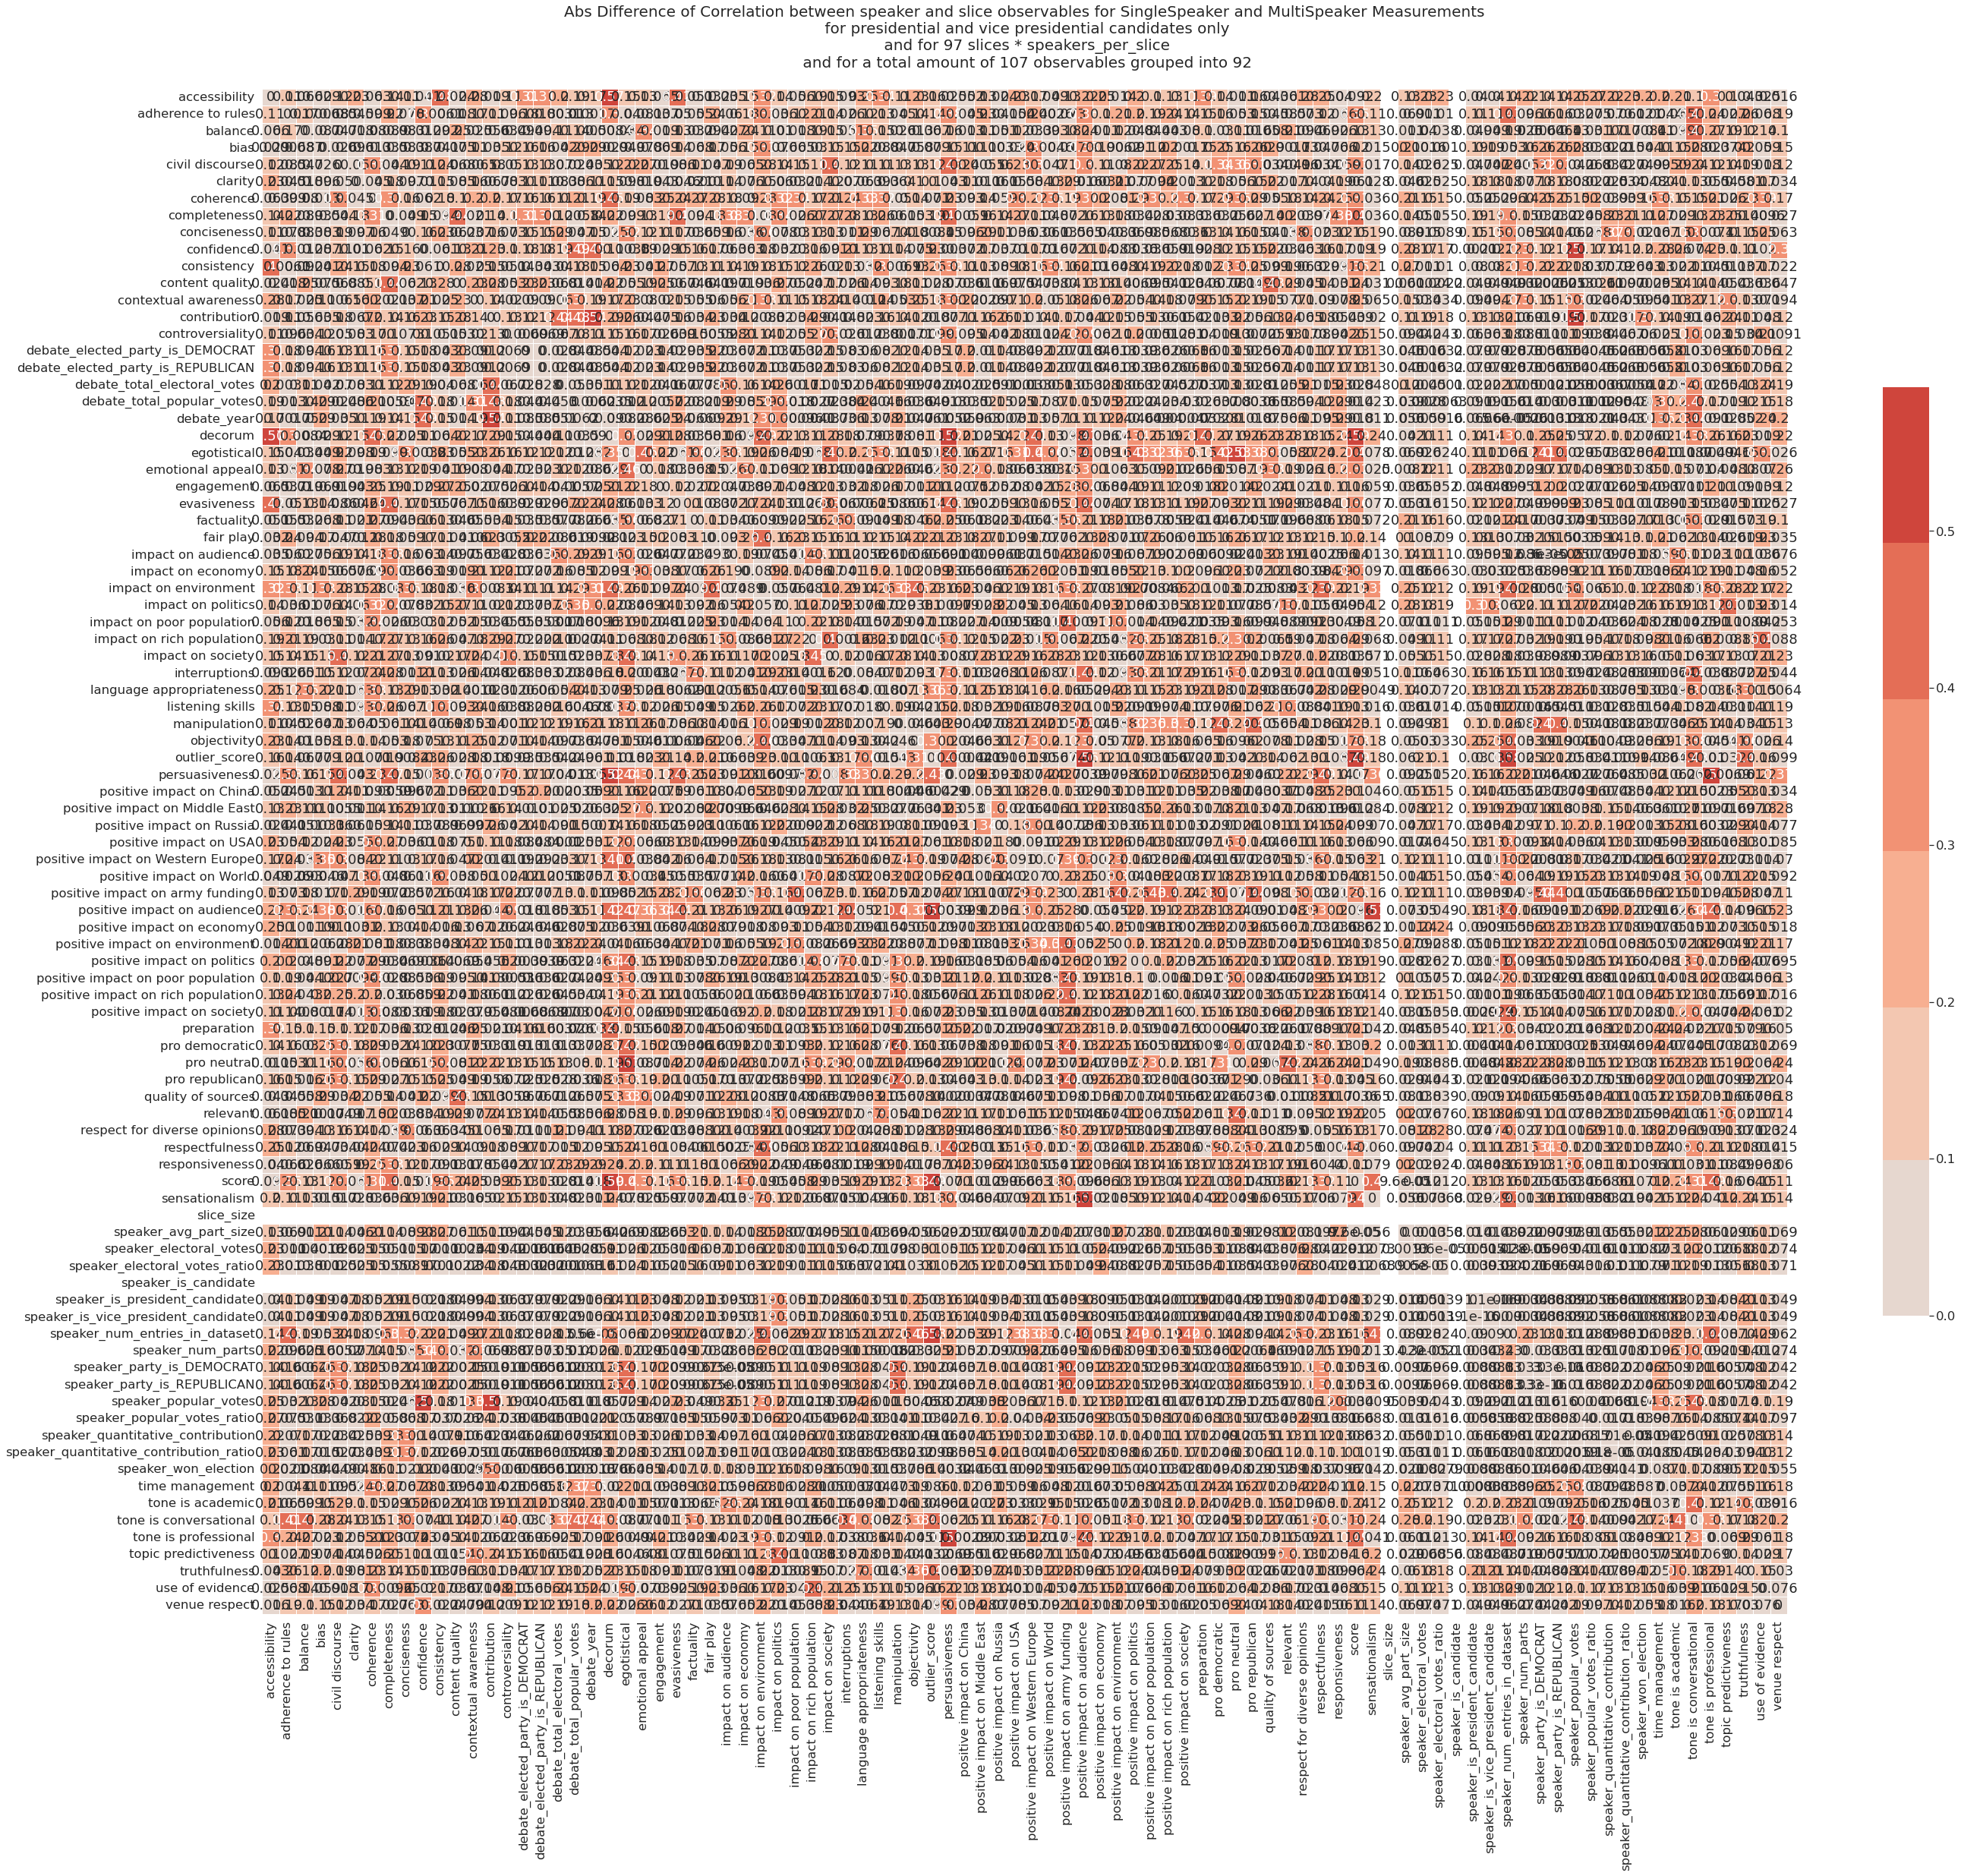

In [13]:
# mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(45, 45))
# create color map between -1 and 1 for heatmap that is dark blue for -1, light blue for -0.5, white for 0, light red for 0.5, dark red for 1
# create color map where the gradient changes faster if there are more values in a bin
cmap = sns.color_palette("coolwarm", 12)

MS_SSO_corr = MS_SSO_corr
# abs of difference between SS_SSO_corr and MS_SSO_corr
data = np.abs(SS_SSO_corr-MS_SSO_corr)
sns.heatmap(data, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
# sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
#             square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.title(f'Abs Difference of Correlation between speaker and slice observables for SingleSpeaker and MultiSpeaker Measurements\n \
for presidential and vice presidential candidates only\n \
and for {len(MS_SSO_grouped_candidates_only_df)} slices * speakers_per_slice\n \
and for a total amount of {n_raw_observables} observables grouped into {n_grouped_observables}\n', fontsize=20)
plt.show()